# Faust to QDax

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/DBraun/DawDreamer/blob/main/examples/Faust_to_QDax/Faust_to_QDax.ipynb)

## License

This notebook borrows heavily from the [QDax MAP-Elites notebook](https://github.com/adaptive-intelligent-robotics/QDax/blob/main/notebooks/mapelites_example.ipynb). Thus, it adheres to this license:

> MIT License
>
> Copyright (c) 2022 Adaptive and Intelligent Robotics Lab and InstaDeep Ltd
> 
> Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:
>
>The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.
>
>THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

## Introduction

[QDax](https://github.com/adaptive-intelligent-robotics/QDax/) is a library of JAX code for Quality-Diversity algorithms, which are a class of neuro-evolution algorithms. The motivation behind QD is that for some problems, multiple and very different solutions can exist. Therefore, we want algorithms that can adequately explore the parameter space without giving too much preference to one region. Luckily, the Faust to JAX pipeline works with QDax! It's particularly useful when the loss landscape is very deceptive or when backpropagation is still too slow.

In this notebook, we'll use [DawDreamer](https://github.com/DBraun/DawDreamer/) to convert a [parametric equalizer](https://en.wikipedia.org/wiki/Equalization_(audio)#Parametric_equalizer) written in [Faust](https://faust.grame.fr/) to a QDax environment. You can try the equalizer in the [Faust IDE](https://faustide.grame.fr/?autorun=1&voices=0&name=faust_parametric_eq&inline=aW1wb3J0KCJzdGRmYXVzdC5saWIiKTsKCi8vIERlZmluZSB0aGUgbnVtYmVyIG9mIHNlY3Rpb25zCk4gPSAzOwoKLy8gRGVmaW5lIHRoZSBwYXJhbWV0ZXJzIGZvciBlYWNoIHNlY3Rpb24uCmdhaW5zID0gLTQwLiwgMy4sIC0yMC47CmZyZXFzID0gNTAwLCA1MDAwLCAxMDAwMDsKYmFuZHdpZHRocyA9IDEwMCwgMjAwMCwgNDAwMDsKLy8gZ2xvYmFsIHZvbHVtZSBwYXJhbWV0ZXIgaW4gZGVjaWJlbHMKdm9sdW1lID0gMC47CgpzZWN0aW9uKGkpID0gaGdyb3VwKCJTZWN0aW9uICVpIiwKICAgIGZpLnBlYWtfZXEoCiAgICAgICAgdnNsaWRlcigiR2FpbiVpIiwgZ2FpbnMgOiBiYS5zZWxlY3RvcihpLCBOKSwgLTgwLiwgMTIuLCAuMDAxKSwgCiAgICAgICAgdnNsaWRlcigiRnJlcSVpIiwgIGZyZXFzIDogYmEuc2VsZWN0b3IoaSwgTiksIDIwLiwgMjAwMDAuLCAuMDAxKSwKICAgICAgICB2c2xpZGVyKCJCYW5kd2lkdGglaSIsIGJhbmR3aWR0aHMgOiBiYS5zZWxlY3RvcihpLCBOKSwgMjAuLCA1MDAwLiwgLjAwMSkKICAgICkKKTsKCi8vIERlZmluZSBhIGZpbmFsIHZvbHVtZSBzbGlkZXIuCnZvbCA9IF8qKHZzbGlkZXIoIlZvbHVtZVt1bml0OmRCXSIsIHZvbHVtZSwgLTEyLiwgMTIuLCAuMDAxKSA6IGJhLmRiMmxpbmVhcik7CgovLyBTZXF1ZW5jZSBhbGwgdGhlIHNlY3Rpb25zLgpwcm9jZXNzID0gaGdyb3VwKCJFcXVhbGl6ZXIiLCBzZXEoaSwgTiwgc2VjdGlvbihpKSkgOiB2b2wpOw%3D%3D). The "target" equalizer and "train" equalizer happen to have the same parameters: three "sections" where each section involves a notch frequency, a gain adjustment, and a bandwidth. The frequency and bandwidth are measured in Hz, and the gain is measured in decibels. Nevertheless, the difference of these ranges doesn't affect our training procedure thanks to how the Faust-to-JAX backend normalizes parameters. With QDax, we use the [CVT MAP-Elites](https://arxiv.org/abs/1610.05729) algorithm to start the train equalizer with random parameter settings and arrive near the target parameters. The fitness function is computed from a time-domain L1-loss of noise going through the target equalizer and that same noise going through the train equalizer.

**This is a toy problem** which is not a true example of a black-box learning algorithm: We not only coded the target equalizer ourself, we also made it have the same parameter space as the train equalizer. However, the approach demonstrated in this notebook does generalize to black-box problems in which we don't know anything about the black-box target system. The target system doesn't need to be differentiable. In this notebook, our *train* system happens to be differentiable, although MAP-Elites doesn't involve differentiation. Other QDax examples such as [OMG-MEGA](https://github.com/adaptive-intelligent-robotics/QDax#qdax-core-algorithms) do use differentiation.

## Installation

**Before installing the requirements, change your Runtime Hardware Accelerator to None.** When Faust is converted to JAX, the resulting code produces audio one sample at a time. CPUs are good for this rather than GPUs/TPUs, so we select None.

Now we can install the requirements:

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install librosa matplotlib flax
    !pip install --no-deps git+https://github.com/adaptive-intelligent-robotics/QDax@main
    !pip install git+https://github.com/google/brax.git@main
else:
    print('skipped installation')

skipped installation


In [2]:
try:
    import dawdreamer
except ModuleNotFoundError:
    !pip install dawdreamer

## Import libraries

In [3]:
import os
import functools
import time
import numpy as np
from functools import partial
from typing import List, Tuple, Union, Dict, Optional

from tqdm.notebook import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.tree_util
from jax import random
from jax.flatten_util import ravel_pytree
import flax.linen as nn

import brax
import brax.envs
from brax.envs.env import State

import qdax
from qdax.core.map_elites import MAPElites
from qdax.core.containers.mapelites_repertoire import compute_cvt_centroids, MapElitesRepertoire
from qdax.core.neuroevolution.mdp_utils import scoring_function
from qdax.core.neuroevolution.buffers.buffer import QDTransition
from qdax.core.emitters.mutation_operators import isoline_variation
from qdax.core.emitters.standard_emitters import MixingEmitter

from qdax.types import Descriptor
from qdax.utils.metrics import CSVLogger, default_qd_metrics
from qdax.utils.plotting import plot_multidimensional_map_elites_grid

from IPython.display import Audio
import IPython.display as ipd

from dawdreamer.faust import FaustContext
from dawdreamer.faust.box import boxFromDSP, boxToSource

# In order to import QDEnv we have to do this monkey patch,
# but we don't use half_cheetah anyway.
brax.envs.half_cheetah = brax.envs.ant  
from qdax.environments import QDEnv

In [4]:
#@title Constants and Utilities

SAMPLE_RATE = 44100

def show_audio(data, autoplay=False):
    if abs(data).max() > 1.:
        data /= abs(data).max()
    
    ipd.display(Audio(data=data, rate=SAMPLE_RATE, normalize=False, autoplay=autoplay))

In [5]:
#@title QD Training Definitions Fields
batch_size = 6  #@param {type:"integer"}
episode_length = 1
num_iterations = 8000  #@param {type:"integer"}
log_period = 20
seed = 42 #@param {type:"integer"}
iso_sigma = 0.005 #@param {type:"number"}
line_sigma = 0.005 #@param {type:"number"}
num_init_cvt_samples = 4096  #@param {type:"integer"}
num_centroids = 6  #@param {type:"integer"}
reward_offset = 1e-6 # minimum reward value to make sure qd_score are positive

In [6]:
#@title Define Target JAX Model and Ground Truth Parameters

# Let's make a parametric equalizer using a sequence of 3 filters.
# https://faustlibraries.grame.fr/libs/filters/#fipeak_eq
# Each "section" adjusts the gain near a certain frequency, with a bandwidth.

Section0_Freq = 500 #@param {type:"number"}
Section0_Gain = -40 #@param {type:"number"}
Section0_Bandwidth = 100 #@param {type:"number"}

Section1_Freq = 5000 #@param {type:"number"}
Section1_Gain = 3 #@param {type:"number"}
Section1_Bandwidth = 2000 #@param {type:"number"}

Section2_Freq = 10000 #@param {type:"number"}
Section2_Gain = -20 #@param {type:"number"}
Section2_Bandwidth = 4000 #@param {type:"number"}

Final_Volume = 0 #@param {type:"number"}

faust_code = f"""
import("stdfaust.lib");

// Define the number of sections
N = 3;

// Define the parameters for each section.
freqs = {Section0_Freq}, {Section1_Freq}, {Section2_Freq};
gains = {Section0_Gain}, {Section1_Gain}, {Section2_Gain};
bandwidths = {Section0_Bandwidth}, {Section1_Bandwidth}, {Section2_Bandwidth};

// global volume parameter in decibels
volume = {Final_Volume};

section(i) = hgroup("Section %i",
    fi.peak_eq(
        vslider("Gain", gains : ba.selector(i, N), -80., 12., .001), 
        vslider("Freq",  freqs : ba.selector(i, N), 20., 20000., .001),
        vslider("Bandwidth", bandwidths : ba.selector(i, N), 20., 5000., .001)
    )
);

// Define a final volume slider.
vol = _*(vslider("Volume[unit:dB]", volume, -12., 12., .001) : ba.db2linear);

// Sequence all the sections.
process = hgroup("Equalizer", seq(i, N, section(i)) : vol);
"""

module_name = "MyDSP"

with FaustContext():
    model_source_code = boxToSource(boxFromDSP(faust_code)[0], 'jax', module_name, ['-a', 'jax/minimal.py'])

custom_globals = {}

exec(model_source_code, custom_globals)  # security risk!

MyDSP = custom_globals[module_name]

model = MyDSP(SAMPLE_RATE)

env_inference_fn = jax.jit(model.apply, static_argnums=[2])

# The number of input channels the model takes.
N_CHANNELS = model.getNumInputs()
print('N_CHANNELS:', N_CHANNELS)

C:\Python39\lib\site-packages\numba\np\arraymath.py:3845: DeprecationWarning: `np.MachAr` is deprecated (NumPy 1.22).
  @overload(np.MachAr)


N_CHANNELS: 1


C:\Python39\lib\site-packages\librosa\core\constantq.py:1059: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.complex,


In [7]:
#@title Initialize Batched Model for Training

N_SECONDS = 1. #@param {type:"number"}
N_SAMPLES = int(SAMPLE_RATE*N_SECONDS)

key = random.PRNGKey(0)
target_variables = model.init({'params': key}, jnp.ones((N_CHANNELS, N_SAMPLES), jnp.float32), N_SAMPLES)
print('target_variables:', target_variables)
# Our behavior descriptor length is the number of parameters.
behavior_descriptor_length = len(target_variables['params'].keys())
print('behavior_descriptor_length:', behavior_descriptor_length)

# show the target intermediate parameters which we want our trained model to discover.
x = -1.+2.*jax.random.uniform(key, (N_CHANNELS, N_SAMPLES))
y, target_parameters = model.apply(target_variables, x, N_SAMPLES, mutable='intermediates')
print('target_parameters:', target_parameters['intermediates'])

random_key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, num=batch_size)
batch_model = nn.vmap(MyDSP, in_axes=(0, None), variable_axes={'params': 0}, split_rngs={'params': True})

# Benchmark the speed of the inference function
env_inference_fn(target_variables, x, N_SAMPLES)
%timeit env_inference_fn(target_variables, x, N_SAMPLES)

target_variables: FrozenDict({
    params: {
        _Equalizer/Section 0/Bandwidth: DeviceArray(-0.9678715, dtype=float32),
        _Equalizer/Section 0/Freq: DeviceArray(-0.951952, dtype=float32),
        _Equalizer/Section 0/Gain: DeviceArray(-0.13043481, dtype=float32),
        _Equalizer/Section 1/Bandwidth: DeviceArray(-0.20481926, dtype=float32),
        _Equalizer/Section 1/Freq: DeviceArray(-0.5015015, dtype=float32),
        _Equalizer/Section 1/Gain: DeviceArray(0.8043479, dtype=float32),
        _Equalizer/Section 2/Bandwidth: DeviceArray(0.59839356, dtype=float32),
        _Equalizer/Section 2/Freq: DeviceArray(-0.001001, dtype=float32),
        _Equalizer/Section 2/Gain: DeviceArray(0.30434787, dtype=float32),
        _Equalizer/Volume: DeviceArray(0., dtype=float32),
    },
})
behavior_descriptor_length: 10
target_parameters: FrozenDict({
    Equalizer/Section 0/Bandwidth: (DeviceArray(100., dtype=float32),),
    Equalizer/Section 0/Freq: (DeviceArray(499.99973, dtype=fl

In [8]:
#@title Define a Custom Environment
class MyEnv(QDEnv):

    @property
    def state_descriptor_length(self) -> int:
        # note: this value doesn't matter for us
        pass

    @property
    def state_descriptor_name(self) -> str:
        # note: this value doesn't matter for us
        pass

    @property
    def state_descriptor_limits(self) -> Tuple[List[float], List[float]]:
        # note: this value doesn't matter for us
        pass

    @property
    def behavior_descriptor_length(self) -> int:
        return behavior_descriptor_length

    @property
    def behavior_descriptor_limits(self) -> Tuple[List[float], List[float]]:
        # When we converted Faust to JAX, all of the parameters were normalized to [-1., 1]
        a_min = [-1. for _ in range(self.behavior_descriptor_length)]
        a_max = [1. for _ in range(self.behavior_descriptor_length)]
        return a_min, a_max

    @property
    def name(self) -> str:
        return "MyEnvFoo"

    @property
    def observation_size(self):
        # note: this value doesn't matter for us
        pass

    @property
    def action_size(self) -> int:
        # note: this value doesn't matter for us
        pass

    def reset(self, rng: jnp.ndarray) -> State:
        """Resets the environment to an initial state."""
        x = -1+2.*jax.random.uniform(rng, (N_CHANNELS, N_SAMPLES))

        # use our ground-truth variables to generate audio
        y = env_inference_fn(target_variables, x, N_SAMPLES)

        obs_init = {'x': x, 'y': y}
        reward, done = jnp.zeros(2)
        metrics: Dict = {}
        info_init = {"state_descriptor": obs_init}
        return State(None, obs_init, reward, done, metrics, info_init)

    def step(self, state: State, actions) -> State:
        """Run one timestep of the environment's dynamics."""

        x, y = state.obs['x'], state.obs['y']

        # use actions (learned parameters) to generate audio prediction
        pred = env_inference_fn(actions, x, N_SAMPLES)

        # L1 time-domain loss
        loss = jnp.abs(pred-y).mean()
        
        # keep reward positive so that the QD-score works correctly.
        reward = jnp.maximum(reward_offset, 1.-loss)

        done = jnp.array(1.0)

        new_obs = state.obs
        # update the state
        return state.replace(obs=new_obs, reward=reward, done=done)  # type: ignore

In [9]:
#@title Initialize environment, and population params
# Init environment
my_env = MyEnv(config=None)

# Init a random key
random_key = jax.random.PRNGKey(seed)

# Create the initial environment states
random_key, subkey = jax.random.split(random_key)
keys = jnp.repeat(jnp.expand_dims(subkey, axis=0), repeats=batch_size, axis=0)
reset_fn = jax.jit(jax.vmap(my_env.reset))
init_states = reset_fn(keys)

# Randomly initialize the parameters:
# Pass a fake batch to get init_variables.
fake_batch = jnp.zeros((batch_size, N_CHANNELS, N_SAMPLES), jnp.float32)
init_variables = batch_model(SAMPLE_RATE).init(subkey, fake_batch, N_SAMPLES)
# The init_variables start as the ground truth,
# so we need to randomize them between -1 and 1
init_variables = jax.tree_util.tree_map(lambda x: random.uniform(key, x.shape, minval=-1, maxval=1, dtype=jnp.float32), init_variables)

In [10]:
#@title Define the function to play a step with the policy in the environment
@jax.jit
def play_step_fn(
        env_state,
        policy_params,
        random_key,
):
    """
    Play an environment step and return the updated state and the transition.
    """

    state_desc = env_state.info["state_descriptor"]
    next_state = my_env.step(env_state, policy_params)

    truncations = None
    next_state_desc = next_state.info["state_descriptor"]

    transition = QDTransition(
        obs=env_state.obs,
        next_obs=next_state.obs,
        rewards=next_state.reward,
        dones=next_state.done,
        actions=policy_params,
        truncations=truncations,
        state_desc=state_desc,
        next_state_desc=next_state_desc,
    )

    return next_state, policy_params, random_key, transition

In [11]:
#@title Define the scoring function and the way metrics are computed

# Prepare the scoring function
def bd_extraction_fn(data: QDTransition, mask: jnp.ndarray) -> Descriptor:

    matrix = jnp.concatenate(list(data.actions['params'].values()), axis=-1)

    # todo:
    # This is an opportunity to have a behavior space
    # that's smaller than the action space.
    # We could project the matrix from (batch_size, #num params)
    # to (batch_size, behavior_descriptor_length).
    # We don't have to do this right now because they happen to already be the same shape.

    # We could also use domain knowledge to define new features based on
    # the actions.

    assert matrix.shape[-1] == behavior_descriptor_length

    return matrix

scoring_fn = functools.partial(
    scoring_function,
    init_states=init_states,
    episode_length=episode_length,
    play_step_fn=play_step_fn,
    behavior_descriptor_extractor=bd_extraction_fn,
)

# Define a metrics function
metrics_function = functools.partial(
    default_qd_metrics,
    qd_offset=reward_offset * episode_length,
)

In [12]:
#@title Define the emitter
variation_fn = functools.partial(
    isoline_variation, iso_sigma=iso_sigma, line_sigma=line_sigma
)

mixing_emitter = MixingEmitter(
    mutation_fn=None,
    variation_fn=variation_fn,
    variation_percentage=1.0,
    batch_size=batch_size
)

In [13]:
#@title Instantiate and initialize the MAP-Elites algorithm

# Instantiate MAP-Elites
map_elites = MAPElites(
    scoring_function=scoring_fn,
    emitter=mixing_emitter,
    metrics_function=metrics_function,
)

# Compute the centroids
centroids, random_key = compute_cvt_centroids(
    num_descriptors=my_env.behavior_descriptor_length,
    num_init_cvt_samples=num_init_cvt_samples,
    num_centroids=num_centroids,
    minval=-1.,
    maxval=1.,
    random_key=random_key,
)

# Compute initial repertoire and emitter state
repertoire, emitter_state, random_key = map_elites.init(init_variables,
                                                        centroids, random_key)

In [14]:
#@title Launch MAP-Elites iterations
num_loops = int(num_iterations / log_period)

csv_logger = CSVLogger(
    "mapelites-logs.csv",
    header=["loop", "iteration", "qd_score", "max_fitness", "coverage", "time"]
)
all_metrics = {}

jit_scan = jax.jit(functools.partial(jax.lax.scan, map_elites.scan_update, xs=(), length=log_period))

pbar = tqdm(range(num_loops))
for i in pbar:
    start_time = time.time()
    (repertoire, emitter_state, random_key,), metrics = jit_scan(
        init=(repertoire, emitter_state, random_key),
    )
    timelapse = time.time() - start_time

    # log metrics
    logged_metrics = {"time": timelapse,
                      "loop": 1+i,
                      "iteration": 1 + i*log_period}
    for key, value in metrics.items():
        # take last value
        logged_metrics[key] = value[-1]

        # take all values
        if key in all_metrics.keys():
            all_metrics[key] = jnp.concatenate([all_metrics[key], value])
        else:
            all_metrics[key] = value

    max_fitness = "{:.4f}".format(metrics['max_fitness'].max())
    pbar.set_description(f"Max Fitness: {max_fitness}")
    csv_logger.log(logged_metrics)

# Save the repertoire
repertoire_path = "./last_repertoire/"
os.makedirs(repertoire_path, exist_ok=True)
repertoire.save(path=repertoire_path)

  0%|          | 0/400 [00:00<?, ?it/s]

C:\Python39\lib\site-packages\qdax\core\emitters\mutation_operators.py:212: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  batch_size = jax.tree_leaves(x1)[0].shape[0]
C:\Python39\lib\site-packages\qdax\core\emitters\mutation_operators.py:227: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  nb_leaves = len(jax.tree_leaves(x1))
C:\Python39\lib\site-packages\qdax\core\emitters\mutation_operators.py:230: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  keys_tree = jax.tree_unflatten(jax.tree_structure(x1), subkeys)
C:\Python39\lib\site-packages\qdax\core\emitters\mutation_operators.py:230: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  keys_tree = jax.tree_unfla

In [15]:
#@title Loading the Repertoire

# Init population of policies
random_key, subkey = jax.random.split(random_key)
fake_params = model.init(subkey, jnp.float32(np.random.random((N_CHANNELS, N_SAMPLES))), N_SAMPLES)

_, reconstruction_fn = ravel_pytree(fake_params)

repertoire = MapElitesRepertoire.load(reconstruction_fn=reconstruction_fn, path=repertoire_path)

In [16]:
#@title Modified plotting code

def plot_map_elites_results(
    env_steps: jnp.ndarray,
    metrics: Dict,
    repertoire: MapElitesRepertoire,
    min_bd: jnp.ndarray,
    max_bd: jnp.ndarray,
    grid_shape: int=2
):
    # Modification of
    # https://github.com/adaptive-intelligent-robotics/QDax/blob/2fb56198f176f0a9be90baa543b172d4915ba0f9/qdax/utils/plotting.py#L215

    """Plots three usual QD metrics, namely the coverage, the maximum fitness
    and the QD-score, along the number of environment steps. This function also
    plots a visualisation of the final map elites grid obtained. It ensures that
    those plots are aligned together to give a simple and efficient visualisation
    of an optimization process.
    Args:
        env_steps: the array containing the number of steps done in the environment.
        metrics: a dictionary containing metrics from the optimizatoin process.
        repertoire: the final repertoire obtained.
        min_bd: the mimimal possible values for the bd.
        max_bd: the maximal possible values for the bd.
    Returns:
        A figure and axes with the plots of the metrics and visualisation of the grid.
    """
    # Customize matplotlib params
    font_size = 16
    params = {
        "axes.labelsize": font_size,
        "axes.titlesize": font_size,
        "legend.fontsize": font_size,
        "xtick.labelsize": font_size,
        "ytick.labelsize": font_size,
        "text.usetex": False,
        "axes.titlepad": 10,
    }

    mpl.rcParams.update(params)

    # Visualize the training evolution and final repertoire
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(40, 10))

    # env_steps = jnp.arange(num_iterations) * episode_length * batch_size

    axes[0].plot(env_steps, metrics["coverage"])
    axes[0].set_xlabel("Environment steps")
    axes[0].set_ylabel("Coverage in %")
    axes[0].set_title("Coverage evolution during training")
    axes[0].set_aspect(0.95 / axes[0].get_data_ratio(), adjustable="box")

    axes[1].plot(env_steps, metrics["max_fitness"])
    axes[1].set_xlabel("Environment steps")
    axes[1].set_ylabel("Maximum fitness")
    axes[1].set_title("Maximum fitness evolution during training")
    axes[1].set_aspect(0.95 / axes[1].get_data_ratio(), adjustable="box")

    axes[2].plot(env_steps, metrics["qd_score"])
    axes[2].set_xlabel("Environment steps")
    axes[2].set_ylabel("QD Score")
    axes[2].set_title("QD Score evolution during training")
    axes[2].set_aspect(0.95 / axes[2].get_data_ratio(), adjustable="box")

    minval = jnp.full((behavior_descriptor_length,), min_bd)
    maxval = jnp.full((behavior_descriptor_length,),  max_bd)
    grid_shape = tuple([2]*behavior_descriptor_length)
    _, axes = plot_multidimensional_map_elites_grid(repertoire,
                                                    minval=minval,
                                                    maxval=maxval,
                                                    grid_shape=grid_shape,
                                                    ax=axes[3])

    return fig, axes

C:\Users\braun\AppData\Local\Temp/ipykernel_77188/2695554554.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


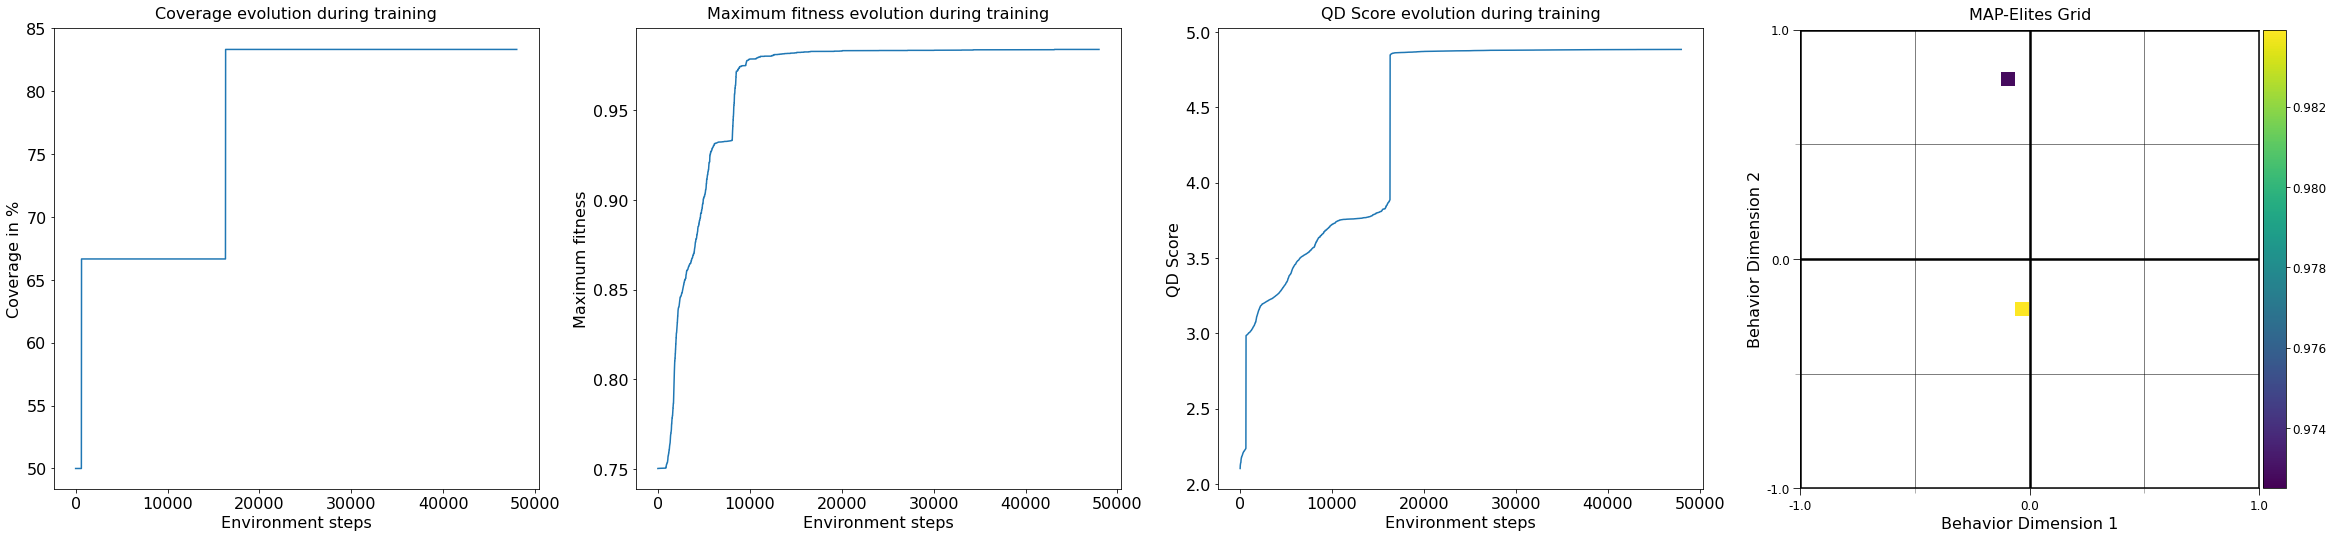

In [17]:
#@title Plotting

# Create the x-axis array
env_steps = jnp.arange(num_iterations) * episode_length * batch_size

# Create the plots and the grid
fig, axes = plot_map_elites_results(env_steps=env_steps, metrics=all_metrics,
                                    repertoire=repertoire,
                                    min_bd=-1., max_bd=1.,
                                    grid_shape=2)

fig.show()

In [18]:
#@title Show the Best Parameters
best_idx = jnp.argmax(repertoire.fitnesses)
best_fitness = jnp.max(repertoire.fitnesses)
best_bd = repertoire.descriptors[best_idx]

print(
    f"Best fitness in the repertoire: {best_fitness:.4f}\n",
    f"Behavior descriptor of the best individual in the repertoire: {best_bd}\n",
    f"Index in the repertoire of this individual: {best_idx}\n"
)

Best fitness in the repertoire: 0.9839
 Behavior descriptor of the best individual in the repertoire: [-0.850714   -0.95248085  0.12625289  0.16665797  0.03976484  0.2751876
  0.00638882 -0.22725333  0.69434154 -0.01048861]
 Index in the repertoire of this individual: 0



In [19]:
#@title Use the best parameters on a single item.

my_params = jax.tree_util.tree_map(
    lambda x: x[best_idx],
    repertoire.genotypes
)

jit_env_reset = jax.jit(my_env.reset)
jit_env_step = jax.jit(my_env.step)
jit_inference_fn = jax.jit(partial(model.apply, mutable='intermediates'), static_argnums=[2])

rng = jax.random.PRNGKey(seed=1)
state = jit_env_reset(rng=rng)

print('input shape: ', state.obs['x'].shape)

action, mod_vars = jit_inference_fn(my_params, state.obs['x'], N_SAMPLES)


# Do some permutation tricks to make the predicted parameters line up with the
# ground truths.

# If you don't care, just print out the variables and visually inspect them:
print('prediction:', mod_vars['intermediates'])

freqs = [(np.array(mod_vars['intermediates'][f"Equalizer/Section {i}/Freq"]).item(), i) for i in range(3)]
freqs = sorted(freqs, key=lambda x: x[0])
suffixes = [x[1] for x in freqs]

keys = [f'Equalizer/Section {i}/{p}' for i in suffixes for p in ['Freq', 'Gain', 'Bandwidth'] ] + ['Equalizer/Volume']
truths = [Section0_Freq, Section0_Gain, Section0_Bandwidth,
          Section1_Freq, Section1_Gain, Section1_Bandwidth,
          Section2_Freq, Section2_Gain, Section2_Bandwidth,
          Final_Volume]

for key, truth in zip(keys, truths):
    msg = f"{key}: " + "{:.3f}".format(np.array(mod_vars['intermediates'][key]).item())
    msg += ' '*(max(0, 20-len(msg)))
    print(f"{msg} truth: {truth}")

input shape:  (1, 44100)
prediction: FrozenDict({
    Equalizer/Section 0/Bandwidth: (DeviceArray(391.72208, dtype=float32),),
    Equalizer/Section 0/Freq: (DeviceArray(494.71628, dtype=float32),),
    Equalizer/Section 0/Gain: (DeviceArray(-28.192368, dtype=float32),),
    Equalizer/Section 1/Bandwidth: (DeviceArray(2924.9783, dtype=float32),),
    Equalizer/Section 1/Freq: (DeviceArray(10407.251, dtype=float32),),
    Equalizer/Section 1/Gain: (DeviceArray(-21.34137, dtype=float32),),
    Equalizer/Section 2/Bandwidth: (DeviceArray(2525.908, dtype=float32),),
    Equalizer/Section 2/Freq: (DeviceArray(7739.7393, dtype=float32),),
    Equalizer/Section 2/Gain: (DeviceArray(-2.0602891, dtype=float32),),
    Equalizer/Volume: (DeviceArray(-0.12586355, dtype=float32),),
})
Equalizer/Section 0/Freq: 494.716 truth: 500
Equalizer/Section 0/Gain: -28.192 truth: -40
Equalizer/Section 0/Bandwidth: 391.722 truth: 100
Equalizer/Section 2/Freq: 7739.739 truth: 5000
Equalizer/Section 2/Gain: -2.0

## Conclusion

The printed numbers above show the three sections and the final volume slider. The first section has a 0 suffix, the second has a 1 suffix, and the third has a 2 suffix. The learned parameters shown above should be close to the target parameters. For example, one section of the parameter was a notch frequency of 500, with a gain of -40 dB, and a bandwidth of 100 Hz. One of those sections of the learned parameters should be close to those numbers. It's ok if the order of the sections is changed because a sequence of peak equalizers is [commutative](https://ccrma.stanford.edu/~jos/filters/Series_Combination_Commutative.html).

## Future Research

Further research could try Faust code with far more trainable parameters. The target system also doesn't need to involve Faust at all. We simply need audio data with which we "reset" the environment. One might use a dataset of diverse sounds such as the [NSynth dataset](https://magenta.tensorflow.org/nsynth). Using [Multi-Objective Quality-Diversity](https://github.com/adaptive-intelligent-robotics/QDax/blob/main/notebooks/mome_example.ipynb) (MOME), one might be able to learn parameters for all of the sounds in parallel.
There are other [QDax notebooks](https://github.com/adaptive-intelligent-robotics/QDax/tree/main/notebooks) worth exploring too.

To take a step beyond a toy problem, in the next section we do some experimental JAX setup of Faust's emulation of the Yamaha DX7 synthesizer.

# Yamaha DX7 Emulation

We can make a Yamaha DX7 synth with Faust. The DX7 has 32 different possible routing algorithms. By default, Faust computes all 32 at once but only returns one in the final output. Since this is expensive, we can hard-code the choice of the algorithm to get more optimized code. We do this in a modification of [`dx.dx7_ui`](https://github.com/grame-cncm/faustlibraries/blob/f53f76ce232575da70bf99f650b715f41bb73646/dx7.lib#L982-L1034) below:

In [20]:
def get_dx7_code(algorithm: int) -> str:
  code = f"""
dx7_ui =
dx.dx7_algo({algorithm},egR1,egR2,egR3,egR4,egL1,egL2,egL3,egL4,outLevel,keyVelSens,ampModSens,opMode,opFreq,opDetune,opRateScale,feedback,lfoDelay,lfoDepth,lfoSpeed,freq,gain,gate) :> _
with{{
    feedback = hslider("global/feedback",0,0,99,1) : dx.dx7_fdbkscalef/(2*ma.PI);
    lfoDelay = hslider("global/lfoDelay",0,0,99,1);
    lfoDepth = hslider("global/lfoDepth",0,0,99,1);
    lfoSpeed = hslider("global/lfoSpeed",0,0,99,1);
    freq = hslider("freq",400,50,1000,0.01);
    gain = hslider("gain",0.8,0,1,0.01);
    gate = button("gate");
    egR1UI = par(i,6,hslider("op%i/egR1",90,0,99,1));
    egR1(n) = ba.take(n+1,egR1UI);
    egR2UI = par(i,6,hslider("op%i/egR2",90,0,99,1));
    egR2(n) = ba.take(n+1,egR2UI);
    egR3UI = par(i,6,hslider("op%i/egR3",90,0,99,1));
    egR3(n) = ba.take(n+1,egR3UI);
    egR4UI = par(i,6,hslider("op%i/egR4",90,0,99,1));
    egR4(n) = ba.take(n+1,egR4UI);
    egL1UI = par(i,6,hslider("op%i/egL1",0,0,99,1));
    egL1(n) = ba.take(n+1,egL1UI);
    egL2UI = par(i,6,hslider("op%i/egL2",90,0,99,1));
    egL2(n) = ba.take(n+1,egL2UI);
    egL3UI = par(i,6,hslider("op%i/egL3",90,0,99,1));
    egL3(n) = ba.take(n+1,egL3UI);
    egL4UI = par(i,6,hslider("op%i/egL4",0,0,99,1));
    egL4(n) = ba.take(n+1,egL4UI);
    outLevelUI = par(i,6,hslider("op%i/level",95,0,99,1));
    outLevel(n) = ba.take(n+1,outLevelUI);
    keyVelSensUI = par(i,6,hslider("op%i/keyVelSens",1,0,8,1));
    keyVelSens(n) = ba.take(n+1,keyVelSensUI);
    ampModSensUI = par(i,6,hslider("op%i/ampModSens",0,0,99,1));
    ampModSens(n) = ba.take(n+1,ampModSensUI);
    opModeUI = par(i,6,nentry("op%i/opMode",0,0,1,1));
    opMode(n) = ba.take(n+1,opModeUI);
    opFreqUI = par(i,6,hslider("op%i/opFreq",1.0,0.0,2.0,0.01));
    opFreq(n) = ba.take(n+1,opFreqUI);
    opDetuneUI = par(i,6,hslider("op%i/opDetune",1,-10,10,1));
    opDetune(n) = ba.take(n+1,opDetuneUI);
    opRateScaleUI = par(i,6,hslider("op%i/opRateScale",0,0,10,1));
    opRateScale(n) = ba.take(n+1,opRateScaleUI);
}};

process = dx7_ui <: _, _;
effect = _, _;
  """
  return code

Now we can load it into DawDreamer.

In [21]:
import dawdreamer as daw

engine = daw.RenderEngine(SAMPLE_RATE, 1)

faust_processor = engine.make_faust_processor("faust")

# enable polyphony
faust_processor.num_voices = 12

dsp_code = get_dx7_code(0)

faust_processor.set_dsp_string(dsp_code)

desc = faust_processor.get_parameters_description()

print(f"Num inputs: {faust_processor.get_num_input_channels()}, outputs: {faust_processor.get_num_output_channels()}")

for par in desc:
    print(par)

# We can pick random settings
# for i, par in enumerate(desc):
#   par_min = par['min']
#   par_max = par['max']
#   value = par_min + (par_max-par_min)*np.random.random()
#   faust_processor.set_parameter(par['index'], value)
#   if np.random.random() < .5:
#     faust_processor.set_parameter(par['name'], value)

# (MIDI note, velocity, start sec, duration sec)
faust_processor.add_midi_note(60, 60, 0.0, .25)
faust_processor.add_midi_note(64, 80, 0.5, .5)
faust_processor.add_midi_note(67, 127, 0.75, .5)

graph = [
    (faust_processor, [])
]

assert(engine.load_graph(graph))

engine.render(2.)

audio = engine.get_audio()

show_audio(audio)

Num inputs: 0, outputs: 2
{'index': 0, 'name': '/Sequencer/DSP1/Polyphonic/Voices/dawdreamer/global/feedback', 'numSteps': 100, 'isDiscrete': False, 'label': 'global/feedback', 'min': 0.0, 'max': 99.0, 'step': 1.0, 'value': 0.0}
{'index': 1, 'name': '/Sequencer/DSP1/Polyphonic/Voices/dawdreamer/op0/egL1', 'numSteps': 100, 'isDiscrete': False, 'label': 'op0/egL1', 'min': 0.0, 'max': 99.0, 'step': 1.0, 'value': 0.0}
{'index': 2, 'name': '/Sequencer/DSP1/Polyphonic/Voices/dawdreamer/op0/egL2', 'numSteps': 100, 'isDiscrete': False, 'label': 'op0/egL2', 'min': 0.0, 'max': 99.0, 'step': 1.0, 'value': 90.0}
{'index': 3, 'name': '/Sequencer/DSP1/Polyphonic/Voices/dawdreamer/op0/egL3', 'numSteps': 100, 'isDiscrete': False, 'label': 'op0/egL3', 'min': 0.0, 'max': 99.0, 'step': 1.0, 'value': 90.0}
{'index': 4, 'name': '/Sequencer/DSP1/Polyphonic/Voices/dawdreamer/op0/egL4', 'numSteps': 100, 'isDiscrete': False, 'label': 'op0/egL4', 'min': 0.0, 'max': 99.0, 'step': 1.0, 'value': 0.0}
{'index': 5, 

In [22]:
# Let's benchmark it
%timeit engine.render(2.)

142 ms ± 827 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


As mentioned in the "Faust to JAX tutorial", we can make this code more [DDSP](https://magenta.tensorflow.org/ddsp)-like by lifting the `freq`, `gain`, `gate` parameters into signal inputs and disabling polyphony.

In [23]:
def get_ddsp_dx7_code(algorithm: int) -> str:
  code = f"""
dx7_ui =
dx.dx7_algo({algorithm},egR1,egR2,egR3,egR4,egL1,egL2,egL3,egL4,outLevel,keyVelSens,ampModSens,opMode,opFreq,opDetune,opRateScale,feedback,lfoDelay,lfoDepth,lfoSpeed) :> _
with{{
    feedback = hslider("global/feedback",0,0,99,1) : dx.dx7_fdbkscalef/(2*ma.PI);
    lfoDelay = hslider("global/lfoDelay",0,0,99,1);
    lfoDepth = hslider("global/lfoDepth",0,0,99,1);
    lfoSpeed = hslider("global/lfoSpeed",0,0,99,1);
    egR1UI = par(i,6,hslider("op%i/egR1",90,0,99,1));
    egR1(n) = ba.take(n+1,egR1UI);
    egR2UI = par(i,6,hslider("op%i/egR2",90,0,99,1));
    egR2(n) = ba.take(n+1,egR2UI);
    egR3UI = par(i,6,hslider("op%i/egR3",90,0,99,1));
    egR3(n) = ba.take(n+1,egR3UI);
    egR4UI = par(i,6,hslider("op%i/egR4",90,0,99,1));
    egR4(n) = ba.take(n+1,egR4UI);
    egL1UI = par(i,6,hslider("op%i/egL1",0,0,99,1));
    egL1(n) = ba.take(n+1,egL1UI);
    egL2UI = par(i,6,hslider("op%i/egL2",90,0,99,1));
    egL2(n) = ba.take(n+1,egL2UI);
    egL3UI = par(i,6,hslider("op%i/egL3",90,0,99,1));
    egL3(n) = ba.take(n+1,egL3UI);
    egL4UI = par(i,6,hslider("op%i/egL4",0,0,99,1));
    egL4(n) = ba.take(n+1,egL4UI);
    outLevelUI = par(i,6,hslider("op%i/level",95,0,99,1));
    outLevel(n) = ba.take(n+1,outLevelUI);
    keyVelSensUI = par(i,6,hslider("op%i/keyVelSens",1,0,8,1));
    keyVelSens(n) = ba.take(n+1,keyVelSensUI);
    ampModSensUI = par(i,6,hslider("op%i/ampModSens",0,0,99,1));
    ampModSens(n) = ba.take(n+1,ampModSensUI);
    opModeUI = par(i,6,nentry("op%i/opMode",0,0,1,1));
    opMode(n) = ba.take(n+1,opModeUI);
    opFreqUI = par(i,6,hslider("op%i/opFreq",1.0,0.0,2.0,0.01));
    opFreq(n) = ba.take(n+1,opFreqUI);
    opDetuneUI = par(i,6,hslider("op%i/opDetune",1,-10,10,1));
    opDetune(n) = ba.take(n+1,opDetuneUI);
    opRateScaleUI = par(i,6,hslider("op%i/opRateScale",0,0,10,1));
    opRateScale(n) = ba.take(n+1,opRateScaleUI);
}};

process = dx7_ui <: _, _;
"""

  return code

ddsp_dx7_code = get_ddsp_dx7_code(0)

# convert to monophonic
faust_processor.num_voices = 0

faust_processor.set_dsp_string(ddsp_dx7_code)

inputs, outputs = faust_processor.get_num_input_channels(), faust_processor.get_num_output_channels()
assert inputs == 3  # (freq, gain, gate)
assert outputs == 2  # stereo

print(f"DawDreamer Num inputs: {inputs}, outputs: {outputs}")

DawDreamer Num inputs: 3, outputs: 2


Now we can convert this monophonic DX7 voice into JAX.

In [24]:
with FaustContext():
    model_source_code = boxToSource(boxFromDSP(ddsp_dx7_code)[0], 'jax', module_name, ['-a', 'jax/minimal.py'])

custom_globals = {}
exec(model_source_code, custom_globals)  # security risk!
# print(model_source_code)

MyDSP = custom_globals[module_name]

model = MyDSP(SAMPLE_RATE)

inputs, outputs = model.getNumInputs(), model.getNumOutputs()
assert inputs == 3  # (freq, gain, gate)
assert outputs == 2  # stereo

print('JAX num inputs: ', inputs, 'num outputs: ', outputs)

JAX num inputs:  3 num outputs:  2


In [25]:
jit_inference_fn = jax.jit(model.apply, static_argnums=[2])

# 2 seconds
T = int(SAMPLE_RATE*2.)

# Hold for 1 second
hold_length = int(SAMPLE_RATE*1.0)

# Play the synth as 440 Hz.
freq = jnp.full((T,), 440.)

# Hold the gain and gate at 1.0 for the hold_length
gain = (jnp.arange(0, T) < hold_length).astype(jnp.float32)
gate = gain

x = jnp.stack([freq, gain, gate], axis=0)

print(x.shape)
assert x.shape[0] == 3  # (freq, gain, gate)

params = model.init({'params': random.PRNGKey(0)}, x, T)['params']
print(params)

(3, 88200)
FrozenDict({
    _dawdreamer/global/feedback: DeviceArray(-1., dtype=float32),
    _dawdreamer/op0/egL1: DeviceArray(-1., dtype=float32),
    _dawdreamer/op0/egL2: DeviceArray(0.8181819, dtype=float32),
    _dawdreamer/op0/egL3: DeviceArray(0.8181819, dtype=float32),
    _dawdreamer/op0/egL4: DeviceArray(-1., dtype=float32),
    _dawdreamer/op0/egR1: DeviceArray(0.8181819, dtype=float32),
    _dawdreamer/op0/egR2: DeviceArray(0.8181819, dtype=float32),
    _dawdreamer/op0/egR3: DeviceArray(0.8181819, dtype=float32),
    _dawdreamer/op0/egR4: DeviceArray(0.8181819, dtype=float32),
    _dawdreamer/op0/keyVelSens: DeviceArray(-0.75, dtype=float32),
    _dawdreamer/op0/level: DeviceArray(0.91919196, dtype=float32),
    _dawdreamer/op0/opDetune: DeviceArray(0.10000002, dtype=float32),
    _dawdreamer/op0/opFreq: DeviceArray(0., dtype=float32),
    _dawdreamer/op0/opMode: DeviceArray([0.7310586 , 0.26894143], dtype=float32),
    _dawdreamer/op0/opRateScale: DeviceArray(-1., dtype=

In [26]:
audio = jit_inference_fn({'params': params}, x, T)
audio = np.array(audio)
show_audio(audio)

In [27]:
# Now that we've jitted it once, subsequent runs should be faster
%timeit jit_inference_fn({'params': params}, x, T)

90.3 ms ± 376 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Our JAX DX7 synthesizer is faster than our DawDreamer synthesizer! The DawDreamer version runs with LLVM and has other DawDreamer-specific miscellaneous overhead. However, our DX7 isn't ready for prime-time yet. If your learning algorithm involves gradients, you shoud modify the underlying [DX7 Faust library](https://github.com/grame-cncm/faustlibraries/blob/master/dx7.lib) so that it doesn't use pre-computed tables for `sine`. This would lead to more accurate gradients. 

## Second Conclusion

Consider combining what you learned here with the Box API colab: [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/DBraun/DawDreamer/blob/main/examples/Box_API/Faust_Box_API.ipynb)

It should be possible to generatively compose boxes and then perform gradient descent or some other optimizer on candidate boxes. There are many opportunities for program synthesis and induction research.